In [1]:
#import dependencies
! pip install tensorboardX
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import json
import os
import sys
import time
from os import path as osp
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader


from model_temporal import LSTMSeqNetwork, BilinearLSTMSeqNetwork, TCNSeqNetwork
from utils import load_config, MSEAverageMeter
from data_Oxiod import *
from transformations import ComposeTransform, RandomHoriRotateSeq
from metric import compute_absolute_trajectory_error, compute_relative_trajectory_error

# torch.multiprocessing.set_sharing_strategy('file_system')
# _nano_to_sec = 1e09
# device = 'cpu'
global _input_channel, _output_channel
_input_channel, _output_channel = 6, 2

In [3]:
import argparse
args = argparse.Namespace()

#Paths to different files
args.type = 'lstm' #choices=['tcn', 'lstm', 'lstm_bi']
args.root_dir = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld'
args.train_list = osp.join(args.root_dir, 'Train-small.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.test_list = osp.join(args.root_dir, 'Test.txt')
args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')



args.test_path = None
args.cache_path = None
args.continue_from = None
args.transfer_from = None


# Params to tune for neural network
args.mode = "train"
args.step_size = 10
args.window_size = 200
args.lr = 1e-04
args.batch_size = 256
args.epochs = 500
args.freeze_params = False
args.save_interval = 20

# # tcn
args.kernel_size = 3
args.channels = [32,64,128,256,72,36]
# # lstm
args.layers = 2
args.layer_size = 50

args.cpu = False
args.device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')
args.run_ekf = False
args.fast_test = False

# Plots and animation
args.show_plot = True
args.saveAnim = False

# Smoothing feature and targets
args.feature_sigma = 2
args.target_sigma = 2

np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

def get_model(args, **kwargs):
    config = {}
    if kwargs.get('dropout'):
        config['dropout'] = kwargs.get('dropout')

    if args.type == 'tcn':
        network = TCNSeqNetwork(_input_channel, _output_channel, args.kernel_size,
                                layer_channels=args.channels, **config)
        print("TCN Network. Receptive field: {} ".format(network.get_receptive_field()))
    elif args.type == 'lstm_bi':
        print("Bilinear LSTM Network")
        network = BilinearLSTMSeqNetwork(_input_channel, _output_channel, args.batch_size, device,
                                         lstm_layers=args.layers, lstm_size=args.layer_size, **config).to(device)
    else:
        print("Simple LSTM Network")
        network = LSTMSeqNetwork(_input_channel, _output_channel, args.batch_size, device,
                                 lstm_layers=args.layers, lstm_size=args.layer_size, **config).to(device)

    pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
    print('Network constructed. trainable parameters: {}'.format(pytorch_total_params))
    return network

In [4]:
class GlobalPosLoss(torch.nn.Module):
    def __init__(self, mode='full', history=None):
        """
        Calculate position loss in global coordinate frame
        Target :- Global Velocity
        Prediction :- Global Velocity
        """
        super(GlobalPosLoss, self).__init__()
        self.mse_loss = torch.nn.MSELoss(reduction='none')

        assert mode in ['full', 'part']
        self.mode = mode
        if self.mode == 'part':
            assert history is not None
            self.history = history
        elif self.mode == 'full':
            self.history = 1

    # shape = [num_dimensions, sequence_length]
    def forward(self, pred, targ):
        gt_pos = torch.cumsum(targ[:, 1:, ], 1)
        pred_pos = torch.cumsum(pred[:, 1:, ], 1)
        if self.mode == 'part':
            gt_pos = gt_pos[:, self.history:, :] - gt_pos[:, :-self.history, :]
            pred_pos = pred_pos[:, self.history:, :] - pred_pos[:, :-self.history, :]
        loss = self.mse_loss(pred_pos, gt_pos)
        return torch.mean(loss)

In [5]:
def write_config(args, **kwargs):
    if args.out_dir:
        with open(osp.join(args.out_dir, 'config.json'), 'w') as f:
            values = vars(args)
            values['file'] = "pytorch_global_position"
            if kwargs:
                values['kwargs'] = kwargs
            json.dump(values, f, sort_keys=True)

In [6]:
def get_dataset(root_dir, data_list, args, **kwargs):
    global _output_channel
    input_format, output_format = [0, 3, 6], [0, _output_channel]
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, [], False
    if mode == 'train':
        args.feature_sigma = 2
        args.target_sigma = 2
        random_shift = args.step_size // 2
        shuffle = True
        #transforms.append(RandomHoriRotateSeq(input_format, output_format))
        transforms = RandomHoriRotateSeq(input_format, output_format)
    elif mode == 'val':
        shuffle = True
        args.feature_sigma = 1
        args.target_sigma = -1
    elif mode == 'test':
        shuffle = False
        grv_only = True
        args.feature_sigma = 2
        args.target_sigma = -1
    transforms = ComposeTransform(transforms)
    
    seq_type = OxfordGlobSpeedSequence
    dataset = SequenceToSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
                                     grv_only=grv_only, transform = None, random_shift = random_shift, feature_sigma = args.feature_sigma, target_sigma = args.target_sigma)
    print(f'step_size: {dataset.step_size}, window_size: {dataset.window_size}')
    return dataset


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)    

In [7]:
def get_loss_function(history, args, **kwargs):
    if args.type == 'tcn':
        config = {'mode': 'part',
                  'history': history}
    else:
        config = {'mode': 'full'}

    criterion = GlobalPosLoss(**config)
    return criterion


def format_string(*argv, sep=' '):
    result = ''
    for val in argv:
        if isinstance(val, (tuple, list, np.ndarray)):
            for v in val:
                result += format_string(v, sep=sep) + sep
        else:
            result += str(val) + sep
    return result[:-1]

In [8]:
def recon_traj_with_preds_global(dataset, preds, ind=None, seq_id=0, type='preds', **kwargs):
    ind = ind if ind is not None else np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int)

    if type == 'gt':
        pos = dataset.gt_pos[seq_id][:, :2]
    else:
        ts = dataset.ts[seq_id]
        # Compute the global velocity from local velocity.
        dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
        pos = preds * dts
        pos[0, :] = dataset.gt_pos[seq_id][0, :2]
        pos = np.cumsum(pos, axis=0)
    veloc = preds
    ori = dataset.orientations[seq_id]

    return pos, veloc, ori

In [9]:
def showAnimation(video_path):
    import ipywidgets as widgets
    from IPython.display import display
    video_widget = widgets.Video.from_file(video_path)
    video_widget.controls = True
    video_widget.autoplay = True
    display(video_widget)

def plotTrajectory(true_x_values, true_y_values, pred_x_values, pred_y_values):    
    plt.figure('{}'.format("Trajectory"), figsize=(16, 9))

    length = len(true_x_values)
    multiplier = 50
    # creating a blank window
    # for the animation
    fig = plt.figure()
    min_x_value = np.min([np.min(true_x_values), np.min(pred_x_values)])
    max_x_value = np.max([np.max(true_x_values), np.max(pred_x_values)])
    min_y_value = np.min([np.min(true_y_values), np.min(pred_y_values)])
    max_y_value = np.max([np.max(true_y_values), np.max(pred_y_values)])
    
    
    axis = plt.axes(xlim =(min_x_value, max_x_value), ylim =(min_y_value, max_y_value))
    
    line1, = axis.plot([], [], 'b', label='Line 1')
    line2, = axis.plot([], [], 'r', label='Line 2')

    def init():
        line1.set_data([], [])
        return line1,
    def init():
        line2.set_data([], [])
        return line2,

    # initializing empty values
    # for x and y co-ordinates
    true_xdata, true_ydata, pred_xdata, pred_ydata = [], [], [], []

    # animation function
    def animate(i):
        true_x = true_x_values[i * multiplier]
        true_y = true_y_values[i * multiplier]
        pred_x = pred_x_values[i * multiplier]
        pred_y = pred_y_values[i * multiplier]
        
        true_xdata.append(true_x)
        true_ydata.append(true_y)
        pred_xdata.append(pred_x)
        pred_ydata.append(pred_y)
        
        line1.set_data(true_xdata, true_ydata)
        line2.set_data(pred_xdata, pred_ydata)

        return line1, line2

    # calling the animation function	
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = int(length/multiplier), interval = 0.01, blit = True)
    return anim

## Normal Train Test

In [141]:
def train(args, **kwargs):
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args, mode='train', **kwargs)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
    end_t = time.time()

    print('Training set loaded. Time usage: {:.3f}s'.format(end_t - start_t))
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val', **kwargs)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
        print('Validation set loaded')

    global device
    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')

    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        #write_config(args)
            
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))
        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    print('\nNumber of train samples: {}'.format(len(train_dataset)))
    train_mini_batches = len(train_loader)
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
        val_mini_batches = len(val_loader)

    network = get_model(args, **kwargs).to(device)
    history = network.get_receptive_field() if args.type == 'tcn' else args.window_size // 2
    criterion = get_loss_function(history, args, **kwargs)
    #criterion = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.75, verbose=True, eps=1e-12)
    quiet_mode = False
    use_scheduler = kwargs.get('use_scheduler', True)

    log_file = None
    if args.out_dir:
        log_file = osp.join(args.out_dir, 'logs', 'log.txt')
        if osp.exists(log_file):
            if args.continue_from is None:
                os.remove(log_file)
            else:
                copyfile(log_file, osp.join(args.out_dir, 'logs', 'log_old.txt'))

    start_epoch = 0
    train_losses_all, val_losses_all = [], []
    # Continues from last model that was trained
    if args.continue_from is not None and osp.exists(args.continue_from):
        checkpoints = torch.load(args.continue_from)
        start_epoch = checkpoints.get('epoch', 0)
        network.load_state_dict(checkpoints.get('model_state_dict'))
        optimizer.load_state_dict(checkpoints.get('optimizer_state_dict'))
    if kwargs.get('force_lr', False):
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr

    step = 0
    best_val_loss = np.inf
    train_errs = np.zeros(args.epochs)

    print("Starting from epoch {}".format(start_epoch))
    try:
        for epoch in range(start_epoch, args.epochs):
            log_line = ''
            network.train()
            train_vel = MSEAverageMeter(3, [2], _output_channel)
            train_loss = 0
            start_t = time.time()

            for bid, batch in enumerate(train_loader):
                feat, targ, _, _ = batch
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                predicted = network(feat)
                train_vel.add(predicted.cpu().detach().numpy(), targ.cpu().detach().numpy())
                loss = criterion(predicted, targ)
                #print('loss: ', loss)
                train_loss += loss.cpu().detach().numpy()
                loss.backward()
                optimizer.step()
                step += 1

            train_errs[epoch] = train_loss / train_mini_batches
            train_losses_all.append(train_loss / train_mini_batches)
            end_t = time.time()
            if not quiet_mode:
                print('-' * 25)
                print('Epoch {}, time usage: {:.3f}s, loss: {}, vel_loss {}/{:.6f}'.format(
                    epoch, end_t - start_t, train_errs[epoch], train_vel.get_channel_avg(), train_vel.get_total_avg()))
            log_line = format_string(log_line, epoch, optimizer.param_groups[0]['lr'], train_errs[epoch],
                                     *train_vel.get_channel_avg())

            saved_model = False
            if val_loader:
                network.eval()
                val_vel = MSEAverageMeter(3, [2], _output_channel)
                val_loss = 0
                for bid, batch in enumerate(val_loader):
                    feat, targ, _, _ = batch
                    feat, targ = feat.to(device), targ.to(device)
                    optimizer.zero_grad()
                    pred = network(feat)
                    val_vel.add(pred.cpu().detach().numpy(), targ.cpu().detach().numpy())
                    val_loss += criterion(pred, targ).cpu().detach().numpy()
                val_loss = val_loss / val_mini_batches
                val_losses_all.append(val_loss)
                log_line = format_string(log_line, val_loss, *val_vel.get_channel_avg())
                if not quiet_mode:
                    print('Validation loss: {} vel_loss: {}/{:.6f}'.format(val_loss, val_vel.get_channel_avg(),
                                                                           val_vel.get_total_avg()))
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    saved_model = True
                    if args.out_dir:
                        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                        torch.save({'model_state_dict': network.state_dict(),
                                    'epoch': epoch,
                                    'loss': train_errs[epoch],
                                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
                        print('Best Validation Model saved to ', model_path)
                if use_scheduler:
                    scheduler.step(val_loss)

            if args.out_dir and not saved_model and (epoch + 1) % args.save_interval == 0:  # save even with validation
                model_path = osp.join(args.out_dir, 'checkpoints', 'icheckpoint_%d.pt' % epoch)
                torch.save({'model_state_dict': network.state_dict(),
                            'epoch': epoch,
                            'loss': train_errs[epoch],
                            'optimizer_state_dict': optimizer.state_dict()}, model_path)
                print('Model saved to ', model_path)

            if log_file:
                log_line += '\n'
                with open(log_file, 'a') as f:
                    f.write(log_line)
            if np.isnan(train_loss):
                print("Invalid value. Stopping training.")
                break
    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training completed')
    if args.out_dir:
        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
        torch.save({'model_state_dict': network.state_dict(),
                    'epoch': epoch,
                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
    return train_losses_all, val_losses_all

In [144]:
def test(args, **kwargs):
    global device, _output_channel
    import matplotlib.pyplot as plt

    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')

    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir if args.root_dir else osp.split(args.test_list)[0]
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args, mode='test')

    if args.out_dir and not osp.exists(args.out_dir):
        os.makedirs(args.out_dir)
        
    if not osp.isdir(osp.join(args.out_dir, 'Videos')) or not osp.isdir(osp.join(args.out_dir, 'Graphs')):
        os.makedirs(osp.join(args.out_dir, 'Videos'))
        os.makedirs(osp.join(args.out_dir, 'Graphs'))
    
    checkpoint = torch.load(args.model_path)
    network = get_model(args, **kwargs)
    network.load_state_dict(checkpoint.get('model_state_dict'))
    network.eval().to(device)
    print('Model {} loaded to device {}.'.format(args.model_path, device))

    # log_file = None
    # if args.test_list and args.out_dir:
    #     log_file = osp.join(args.out_dir, osp.split(args.test_list)[-1].split('.')[0] + '_log.txt')
    #     with open(log_file, 'w') as f:
    #         f.write(args.model_path + '\n')
    #         f.write('Seq traj_len velocity ate rte\n')

    losses_vel = MSEAverageMeter(2, [1], _output_channel)
    ate_all, rte_all = [], []
    pred_per_min = 200 * 60

    seq_dataset = get_dataset(root_dir, test_data_list, args, mode='test', **kwargs)

    for idx, data in enumerate(test_data_list):
        #assert data == osp.split(seq_dataset.data_path[idx])[1]
        feat, vel = seq_dataset.get_test_seq(idx)
        feat = torch.Tensor(feat).to(device)
        preds = np.squeeze(network(feat).cpu().detach().numpy())[-vel.shape[0]:, :_output_channel]
        
        ind = np.arange(vel.shape[0])
        vel_losses = np.mean((vel - preds) ** 2, axis=0)
        losses_vel.add(vel, preds)

        print('Reconstructing trajectory')
        pos_pred, gv_pred, _ = recon_traj_with_preds_global(seq_dataset, preds, ind=ind, type='pred', seq_id=idx)
        pos_gt, gv_gt, _ = recon_traj_with_preds_global(seq_dataset, vel, ind=ind, type='gt', seq_id=idx)

        

        ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
        if pos_pred.shape[0] < pred_per_min:
            ratio = pred_per_min / pos_pred.shape[0]
            rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
        else:
            rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pred_per_min)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)
        ate_all.append(ate)
        rte_all.append(rte)

        print('Sequence {}, Velocity loss {} / {}, ATE: {}, RTE:{}'.format(data, vel_losses, np.mean(vel_losses), ate,
                                                                           rte))
        log_line = format_string(data, np.mean(vel_losses), ate, rte)

        kp = 2
        targ_names = ['vx', 'vy']

        if args.out_dir is not None and osp.isdir(args.out_dir) and args.saveAnim:
            video_path = osp.join(args.out_dir, 'Videos/' + ''.join(data.split('/')) +'_Trajectory.mp4')
            animation = plotTrajectory(pos_gt[:, 0], pos_gt[:, 1], pos_pred[:, 0], pos_pred[:, 1])
            animation.save(video_path, writer = 'ffmpeg', fps = 50, bitrate = 700)
            showAnimation(video_path)
            
        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            plt.plot(ind, preds[:, i])
            plt.plot(ind, vel[:, i])
            plt.legend(['Predicted', 'Ground truth'])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], vel_losses[i]))
        plt.tight_layout()
        
        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.png'))
            
        if args.show_plot:
            plt.show()

        # if args.out_dir is not None and osp.isdir(args.out_dir):
        #     np.save(osp.join(args.out_dir, '{}_{}.npy'.format(data, args.type)),
        #             np.concatenate([pos_pred, pos_gt], axis=1))
        # if args.out_dir is not None and osp.isdir(args.out_dir):
        #     plt.savefig(osp.join(args.out_dir, '{}_{}.png'.format(data, args.type)))
        plt.close('all')

    ate_all = np.array(ate_all)
    rte_all = np.array(rte_all)

    measure = format_string('ATE', 'RTE', sep='\t')
    values = format_string(np.mean(ate_all), np.mean(rte_all), sep='\t')
    print(measure, '\n', values)

In [ ]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['handbag']
i = 1
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
args.epochs = 300
# # lstm
args.layers = 3
args.layer_size = 40
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train.txt')
    args.val_list = osp.join(args.root_dir, 'Validation.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    #args.continue_from = args.model_path
    args.continue_from = None
    train_losses, val_losses = train(args)
    plt.subplot(math.ceil(len(data_path_list) / 2), 2 , i)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(data+' training loss')
    plt.legend(['train_loss', 'val_loss'])
    i += 1

In [ ]:
args.saveAnim = True
args.batch_size = 1
args.target_sigma = -1
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['handbag']
for data in data_path_list:
    print(f'=============================================================================outputs for {data} ==============================================================')
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.test_list = osp.join(args.root_dir, 'Test.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    test(args)

## Hyper Param Tuning

#### Parameters to tune:

### Current
- batch_size
- learning rate
- layers
- layer_size
- window_size
- step_size

In [10]:
! pip install ray
from functools import partial
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [11]:
def train_tune(config, data_dir):
    args.batch_size = config['batch_size']
    args.lr = config['lr']
    args.layer_size = config['layer_size']
    args.layers = config['layers']
    args.window_size = config['window_size']
    args.step_size = config['step_size']
    
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args, mode='train')
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
    end_t = time.time()

    print('Training set loaded. Time usage: {:.3f}s'.format(end_t - start_t))
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val')
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
        print('Validation set loaded')

    global device
    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')

    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        #write_config(args)
            
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))
        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    print('\nNumber of train samples: {}'.format(len(train_dataset)))
    train_mini_batches = len(train_loader)
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
        val_mini_batches = len(val_loader)

    network = get_model(args).to(device)
    history = network.get_receptive_field() if args.type == 'tcn' else args.window_size // 2
    criterion = get_loss_function(history, args)
    criterion = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.75, verbose=True, eps=1e-12)
    quiet_mode = False
    use_scheduler = True

    log_file = None
    if args.out_dir:
        log_file = osp.join(args.out_dir, 'logs', 'log.txt')
        if osp.exists(log_file):
            if args.continue_from is None:
                os.remove(log_file)
            else:
                copyfile(log_file, osp.join(args.out_dir, 'logs', 'log_old.txt'))

    start_epoch = 0
    train_losses_all, val_losses_all = [], []
    
    
    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        network.load_state_dict(checkpoint_state["model_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    step = 0
    best_val_loss = np.inf
    train_errs = np.zeros(args.epochs)

    print("Starting from epoch {}".format(start_epoch))
    try:
        for epoch in range(start_epoch, args.epochs):
            log_line = ''
            network.train()
            train_vel = MSEAverageMeter(3, [2], _output_channel)
            train_loss = 0
            start_t = time.time()

            for bid, batch in enumerate(train_loader):
                feat, targ, _, _ = batch
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                predicted = network(feat)
                train_vel.add(predicted.cpu().detach().numpy(), targ.cpu().detach().numpy())
                loss = criterion(predicted, targ)
                #print('loss: ', loss)
                train_loss += loss.cpu().detach().numpy()
                loss.backward()
                optimizer.step()
                step += 1

            train_errs[epoch] = train_loss / train_mini_batches
            train_losses_all.append(train_loss / train_mini_batches)
            end_t = time.time()
            if not quiet_mode and epoch%20 == 0:
                print('-' * 25)
                print('Epoch {}, time usage: {:.3f}s, loss: {}, vel_loss {}/{:.6f}'.format(
                    epoch, end_t - start_t, train_errs[epoch], train_vel.get_channel_avg(), train_vel.get_total_avg()))
            log_line = format_string(log_line, epoch, optimizer.param_groups[0]['lr'], train_errs[epoch],
                                     *train_vel.get_channel_avg())

            saved_model = False
            if val_loader:
                network.eval()
                val_vel = MSEAverageMeter(3, [2], _output_channel)
                val_loss = 0
                for bid, batch in enumerate(val_loader):
                    feat, targ, _, _ = batch
                    feat, targ = feat.to(device), targ.to(device)
                    optimizer.zero_grad()
                    pred = network(feat)
                    val_vel.add(pred.cpu().detach().numpy(), targ.cpu().detach().numpy())
                    val_loss += criterion(pred, targ).cpu().detach().numpy()
                val_loss = val_loss / val_mini_batches
                val_losses_all.append(val_loss)
                log_line = format_string(log_line, val_loss, *val_vel.get_channel_avg())
                if not quiet_mode and epoch%20 == 0:
                    print('Validation loss: {} vel_loss: {}/{:.6f}'.format(val_loss, val_vel.get_channel_avg(),
                                                                           val_vel.get_total_avg()))
            checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": network.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
            }
            checkpoint = Checkpoint.from_dict(checkpoint_data)
            
            session.report({"loss": val_loss},checkpoint=checkpoint)
            
    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training completed')
    if args.out_dir:
        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
        torch.save({'model_state_dict': network.state_dict(),
                    'epoch': epoch,
                    'optimizer_state_dict': optimizer.state_dict()}, model_path)

In [12]:
def test_tune(best_trial, args, **kwargs):
    global device, _output_channel
    import matplotlib.pyplot as plt

    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')

    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir if args.root_dir else osp.split(args.test_list)[0]
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args, mode='test')

    if args.out_dir and not osp.exists(args.out_dir):
        os.makedirs(args.out_dir)
        
    if not osp.isdir(osp.join(args.out_dir, 'Videos')) or not osp.isdir(osp.join(args.out_dir, 'Graphs')):
        os.makedirs(osp.join(args.out_dir, 'Videos'))
        os.makedirs(osp.join(args.out_dir, 'Graphs'))

    best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()
    network = get_model(args, **kwargs)
    network.load_state_dict(best_checkpoint_data["model_state_dict"])
    
    losses_vel = MSEAverageMeter(2, [1], _output_channel)
    ate_all, rte_all = [], []
    pred_per_min = 200 * 60

    seq_dataset = get_dataset(root_dir, test_data_list, args, mode='test', **kwargs)

    for idx, data in enumerate(test_data_list):
        #assert data == osp.split(seq_dataset.data_path[idx])[1]
        feat, vel = seq_dataset.get_test_seq(idx)
        feat = torch.Tensor(feat).to(device)
        preds = np.squeeze(network(feat).cpu().detach().numpy())[-vel.shape[0]:, :_output_channel]
        
        ind = np.arange(vel.shape[0])
        vel_losses = np.mean((vel - preds) ** 2, axis=0)
        losses_vel.add(vel, preds)

        print('Reconstructing trajectory')
        pos_pred, gv_pred, _ = recon_traj_with_preds_global(seq_dataset, preds, ind=ind, type='pred', seq_id=idx)
        pos_gt, gv_gt, _ = recon_traj_with_preds_global(seq_dataset, vel, ind=ind, type='gt', seq_id=idx)

        

        ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
        if pos_pred.shape[0] < pred_per_min:
            ratio = pred_per_min / pos_pred.shape[0]
            rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
        else:
            rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pred_per_min)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)
        ate_all.append(ate)
        rte_all.append(rte)

        print('Sequence {}, Velocity loss {} / {}, ATE: {}, RTE:{}'.format(data, vel_losses, np.mean(vel_losses), ate,
                                                                           rte))
        log_line = format_string(data, np.mean(vel_losses), ate, rte)

        kp = 2
        targ_names = ['vx', 'vy']

        if args.out_dir is not None and osp.isdir(args.out_dir) and args.saveAnim:
            video_path = osp.join(args.out_dir, 'Videos/' + ''.join(data.split('/')) +'_Trajectory.mp4')
            animation = plotTrajectory(pos_gt[:, 0], pos_gt[:, 1], pos_pred[:, 0], pos_pred[:, 1])
            animation.save(video_path, writer = 'ffmpeg', fps = 50, bitrate = 700)
            showAnimation(video_path)
            
        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            plt.plot(ind, preds[:, i])
            plt.plot(ind, vel[:, i])
            plt.legend(['Predicted', 'Ground truth'])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], vel_losses[i]))
        plt.tight_layout()
        
        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.png'))
            
        if args.show_plot:
            plt.show()

        # if args.out_dir is not None and osp.isdir(args.out_dir):
        #     np.save(osp.join(args.out_dir, '{}_{}.npy'.format(data, args.type)),
        #             np.concatenate([pos_pred, pos_gt], axis=1))
        # if args.out_dir is not None and osp.isdir(args.out_dir):
        #     plt.savefig(osp.join(args.out_dir, '{}_{}.png'.format(data, args.type)))
        plt.close('all')

    ate_all = np.array(ate_all)
    rte_all = np.array(rte_all)

    measure = format_string('ATE', 'RTE', sep='\t')
    values = format_string(np.mean(ate_all), np.mean(rte_all), sep='\t')
    print(measure, '\n', values)

In [14]:
config = {
    "batch_size": tune.choice([32,64,128]),
    "layers": tune.choice([2,3]),
    "lr": tune.loguniform(1e-3, 1e-1),
    "layer_size": tune.choice([10, 20, 30, 40]),
    "window_size": tune.choice([300, 400, 500]),
    "step_size": tune.choice([10, 15, 20, 25])
}

args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', 'running')
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.out_dir = 'home/jovyan/dummyoutput'
args.epochs = 200

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=args.epochs,
        grace_period=20,
        reduction_factor=2,
    )
result = tune.run(
    partial(train_tune, data_dir=args.root_dir),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=15,
    scheduler= scheduler,
    checkpoint_at_end=False)

2023-06-27 06:54:31,188	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-27 06:54:32,122	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


(func pid=38046) step_size: 25, window_size: 400
(func pid=38046) Training set loaded. Time usage: 0.615s
(func pid=38046) step_size: 25, window_size: 400
(func pid=38046) Validation set loaded
(func pid=38046) 
(func pid=38046) Number of train samples: 9967
(func pid=38046) Number of val samples: 2285
(func pid=38046) Simple LSTM Network
(func pid=38046) Network constructed. trainable parameters: 5832
(func pid=38046) Starting from epoch 0
(func pid=38046) -------------------------
(func pid=38046) Epoch 0, time usage: 1.611s, loss: 0.22882866497687587, vel_loss [0.21493857 0.24271837]/0.228828


Trial name,date,done,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_tune_781d7_00000,2023-06-27_06-59-30,True,andrew-notebook1-0,200,0.068575,10.233.98.56,38046,True,294.849,1.46001,294.849,1687849170,200,781d7_00000
train_tune_781d7_00001,2023-06-27_06-59-49,True,andrew-notebook1-0,20,0.0769031,10.233.98.56,38480,True,15.699,0.735646,15.699,1687849189,20,781d7_00001
train_tune_781d7_00002,2023-06-27_07-00-30,True,andrew-notebook1-0,20,0.405377,10.233.98.56,38611,True,37.8227,1.88021,37.8227,1687849230,20,781d7_00002
train_tune_781d7_00003,2023-06-27_07-01-06,True,andrew-notebook1-0,20,0.791078,10.233.98.56,38745,True,33.3074,1.59747,33.3074,1687849266,20,781d7_00003
train_tune_781d7_00004,2023-06-27_07-02-42,True,andrew-notebook1-0,40,0.0720597,10.233.98.56,38879,True,91.846,2.22562,91.846,1687849362,40,781d7_00004
train_tune_781d7_00005,2023-06-27_07-08-40,True,andrew-notebook1-0,200,nan,10.233.98.56,39046,True,354.566,1.83651,354.566,1687849720,200,781d7_00005
train_tune_781d7_00006,2023-06-27_07-14-40,True,andrew-notebook1-0,200,0.0708636,10.233.98.56,39445,True,356.446,1.76892,356.446,1687850080,200,781d7_00006
train_tune_781d7_00007,2023-06-27_07-15-10,True,andrew-notebook1-0,20,0.0801492,10.233.98.56,39846,True,26.0323,1.23381,26.0323,1687850110,20,781d7_00007
train_tune_781d7_00008,2023-06-27_07-18-51,True,andrew-notebook1-0,160,0.158217,10.233.98.56,39977,True,217.514,1.33556,217.514,1687850331,160,781d7_00008
train_tune_781d7_00009,2023-06-27_07-19-42,True,andrew-notebook1-0,20,0.09952,10.233.98.56,40300,True,47.8227,2.35178,47.8227,1687850382,20,781d7_00009


(func pid=38046) Validation loss: 0.15504398312367185 vel_loss: [0.16726985 0.14281785]/0.155044
(func pid=38046) -------------------------
(func pid=38046) Epoch 20, time usage: 1.286s, loss: 0.03579159019892239, vel_loss [0.03655666 0.03502646]/0.035792
(func pid=38046) Validation loss: 0.07287056801814429 vel_loss: [0.07793269 0.06780833]/0.072871
(func pid=38046) -------------------------
(func pid=38046) Epoch 40, time usage: 1.301s, loss: 0.029103406168927717, vel_loss [0.02953332 0.02867343]/0.029103
(func pid=38046) Validation loss: 0.06643364840829877 vel_loss: [0.07269158 0.06017559]/0.066434
(func pid=38046) -------------------------
(func pid=38046) Epoch 60, time usage: 1.329s, loss: 0.0261318451302707, vel_loss [0.02627038 0.02599325]/0.026132
(func pid=38046) Validation loss: 0.069570445888479 vel_loss: [0.07343315 0.06570761]/0.069570
(func pid=38046) -------------------------
(func pid=38046) Epoch 80, time usage: 1.310s, loss: 0.024220262920645656, vel_loss [0.0246344

2023-06-27 07:35:01,411	INFO tune.py:1111 -- Total run time: 2429.29 seconds (2429.13 seconds for the tuning loop).


Best trial config: {'batch_size': 32, 'layers': 2, 'lr': 0.007073592504535202, 'layer_size': 30, 'window_size': 500, 'step_size': 20}
Best trial final validation loss: 0.057310678911480034
step_size: 10, window_size: 200
Simple LSTM Network
Network constructed. trainable parameters: 12332
step_size: 10, window_size: 200
feature shape:  (1, 69113, 6)
target shape:  [[1.312981 0.779989]
 [1.287981 0.809988]
 [1.245982 0.849988]
 ...
 [-0.099999 0.069999]
 [-0.089999 0.069999]
 [-0.099999 0.059999]]
Reconstructing trajectory
Sequence data1/combined1.csv, Velocity loss [0.005031 0.005009] / 0.00502020213752985, ATE: 7.04045846074351, RTE:2.2416720376191215


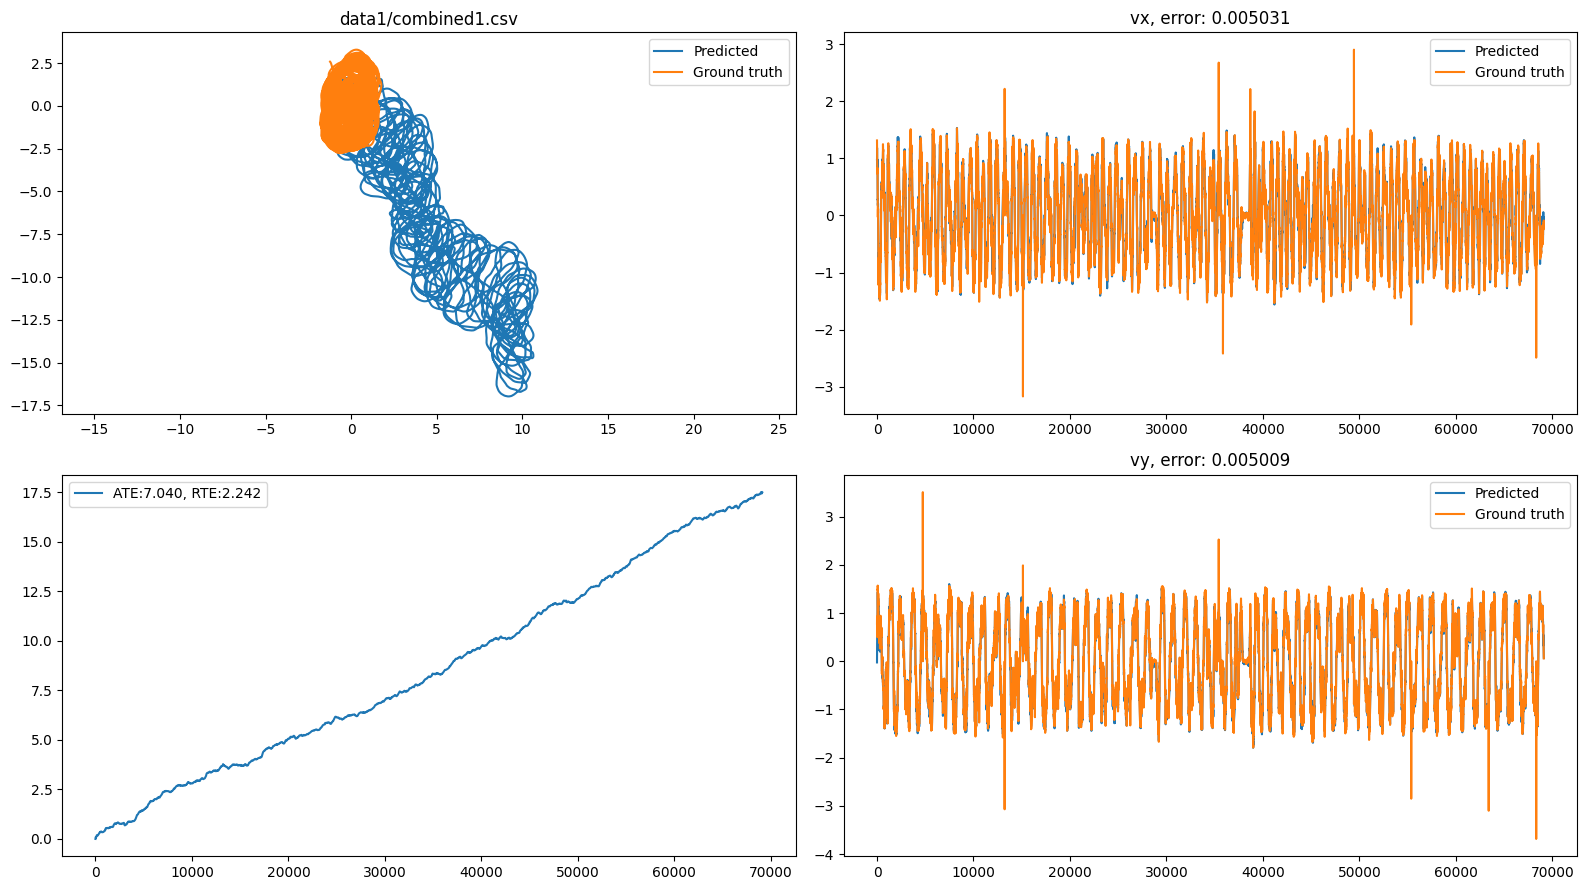

feature shape:  (1, 62342, 6)
target shape:  [[1.015984 -1.511976]
 [1.028983 -1.507976]
 [1.013984 -1.485976]
 ...
 [0.000000 0.000000]
 [0.000000 0.010000]
 [0.010000 -0.010000]]
Reconstructing trajectory
Sequence data1/combined2.csv, Velocity loss [0.013705 0.015999] / 0.01485179178416729, ATE: 6.408151898942197, RTE:2.3299677403483914


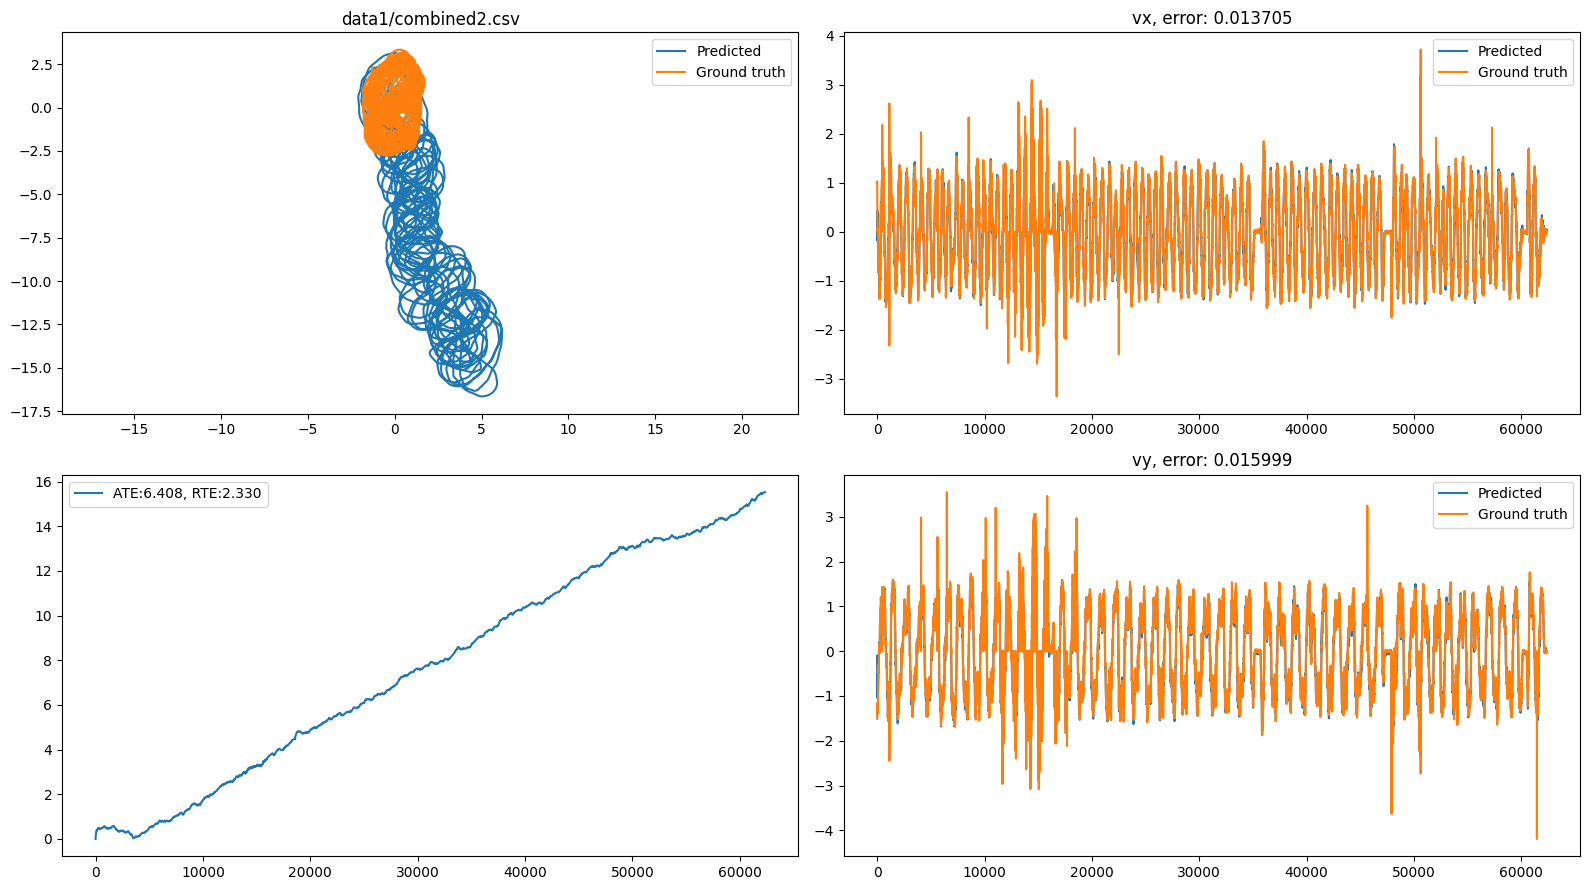

feature shape:  (1, 58970, 6)
target shape:  [[-0.009000 0.000000]
 [-0.007000 0.000000]
 [-0.004000 0.000000]
 ...
 [-0.139998 0.749987]
 [-0.135998 0.759987]
 [-0.212996 1.559974]]
Reconstructing trajectory
Sequence data1/combined3.csv, Velocity loss [0.010541 0.012629] / 0.0115850530564785, ATE: 5.808052309407025, RTE:2.2108835440466055


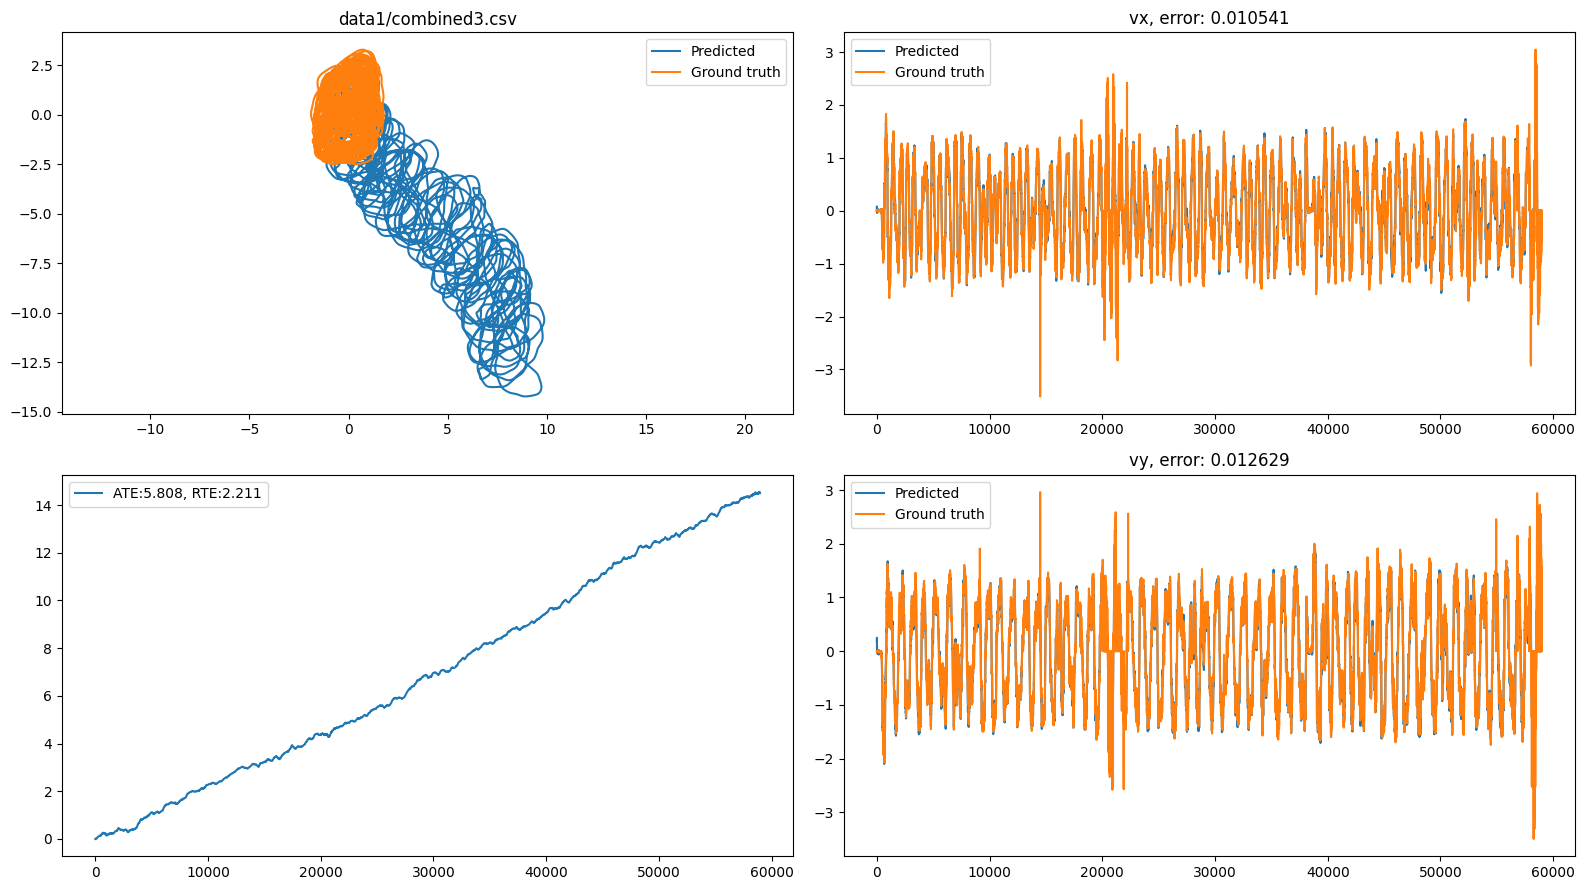

feature shape:  (1, 60321, 6)
target shape:  [[0.039999 0.020000]
 [-0.010000 0.039999]
 [0.010000 0.020000]
 ...
 [0.020000 0.010000]
 [0.020000 0.010000]
 [0.030000 0.010000]]
Reconstructing trajectory
Sequence data1/combined4.csv, Velocity loss [0.005341 0.005301] / 0.0053210025653243065, ATE: 4.633076244502877, RTE:1.6456417239522514


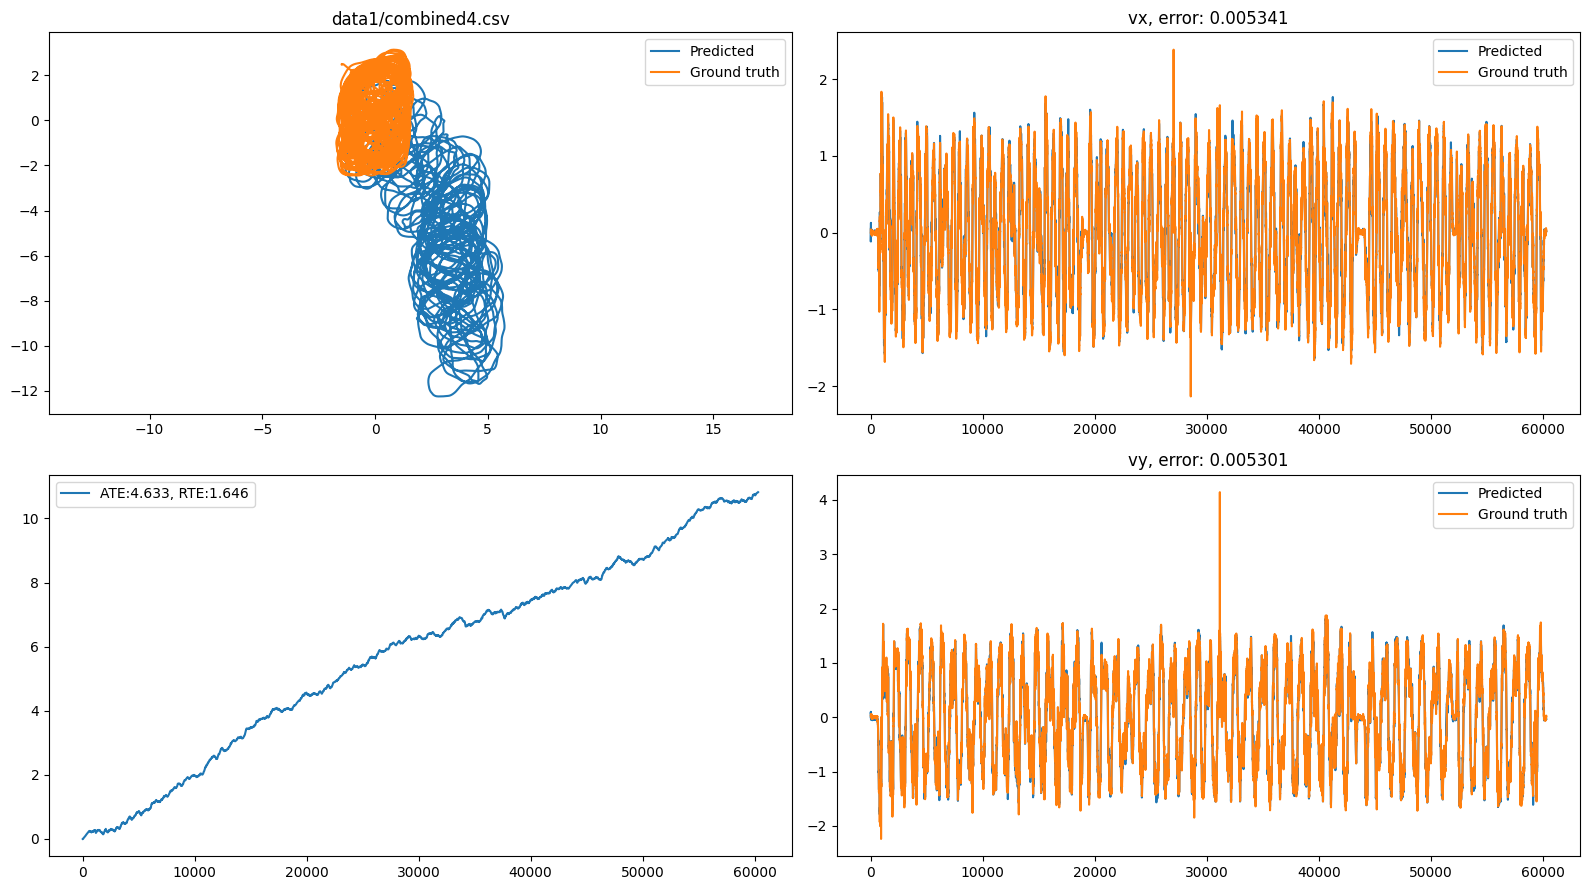

ATE	RTE 
 5.972434728398903	2.1070412614915925


*** SIGTERM received at time=1687851641 on cpu 20 ***
PC: @     0x7f07919c346e  (unknown)  epoll_wait
    @     0x7f07918e7090  (unknown)  (unknown)
[2023-06-27 07:40:41,584 E 37352 37352] logging.cc:361: *** SIGTERM received at time=1687851641 on cpu 20 ***
[2023-06-27 07:40:41,584 E 37352 37352] logging.cc:361: PC: @     0x7f07919c346e  (unknown)  epoll_wait
[2023-06-27 07:40:41,584 E 37352 37352] logging.cc:361:     @     0x7f07918e7090  (unknown)  (unknown)


In [16]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
args.out_dir = 'home/jovyan/dummyoutput'
args.layer_size = best_trial.config['layer_size']
args.layers = best_trial.config['layers']
args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', 'running')
args.test_list = osp.join(args.root_dir, 'Train.txt')
args.batch_size = 1

test_tune(best_trial, args)